# Dataset 1: CM_SAF SARAH2.1 (Sunshine Duration Unit Feature Only)

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

## Read in sunshine hours

### Read in NetCDF and convert to dataframes

In [2]:
path_to_netCDF_sunhours = "E:\ORD49239"
df_parts = []
for netcdf_file in tqdm(glob.glob(f"{path_to_netCDF_sunhours}\*")):
    ds_part = xr.open_dataset(netcdf_file, engine='netcdf4')
    df_parts.append(ds_part.to_dataframe())
    break # TODO: Remove after debugging

  0%|          | 0/192 [00:01<?, ?it/s]


### Handle NaNs

* Where do the NaNs come from: I assume they come from stations not recording values on a certain date. Since
we are interested in averages over countries as a whole, it should not pose an issue to drop them. This will also
reduce the number of rows.

In [3]:
test_df = df_parts[0].dropna().reset_index()
test_df.head()

,lon,lat,time,SDU
0,-65.0,-22.299999,2000-01-01,110.577332
1,-65.0,-22.250000,2000-01-01,114.464058
2,-65.0,-22.200001,2000-01-01,121.085159
3,-65.0,-22.150000,2000-01-01,120.345100
4,-65.0,-22.100000,2000-01-01,121.679955


### Reduce dataset size by excluding non-EU countries

We can do this by loading the world map, filtering out the EU countries
and then removing all coordinates outside the min-max square of the EU.

For this, the following shape file will be used to define coordinate bounds
between countries:

In [4]:
import geopandas as gpd

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world.continent == 'Europe']

#### Ignored countries (Blacklist)
In this section, we define countries to leave out of the processing by adding their country
codes in ISO_A3 to the list below:

In [6]:
ignored_countries = ['RUS']
europe = europe[~europe['iso_a3'].isin(ignored_countries)]

### Map coordinates to country

We use geopandas to merge the world borders with the dataset by long/lat

In [7]:
gdf = gpd.GeoDataFrame(test_df, geometry=gpd.points_from_xy(test_df.lon, test_df.lat))

Calculate median SDU (sunshine duration) per country in europe:

In [8]:
gdf_country = gpd.sjoin(gdf, europe, how='inner')
gdf_country.head()

C:\Users\phili\AppData\Local\Temp\ipykernel_17596\2981836489.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_country = gpd.sjoin(gdf, europe, how='inner')


,lon,lat,time,SDU,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
278892,-54.500000,2.35,2000-01-01,138.491837,POINT (-54.50000 2.35000),43,67059887.0,Europe,France,FRA,2715518
280560,-54.450001,2.30,2000-01-01,140.067657,POINT (-54.45000 2.30000),43,67059887.0,Europe,France,FRA,2715518
280561,-54.450001,2.35,2000-01-01,139.915192,POINT (-54.45000 2.35000),43,67059887.0,Europe,France,FRA,2715518
280562,-54.450001,2.40,2000-01-01,135.425186,POINT (-54.45000 2.40000),43,67059887.0,Europe,France,FRA,2715518
280607,-54.450001,4.65,2000-01-01,153.570526,POINT (-54.45000 4.65000),43,67059887.0,Europe,France,FRA,2715518


In [9]:
gdf_country_median = gdf_country.groupby('name').median().loc[:, ['SDU']]
gdf_country_median.head()

,SDU
name,
Albania,166.964035
Austria,68.798660
Belarus,33.689892
Belgium,58.523132
Bosnia and Herz.,87.071968


### Create a cloropleth plot for SDU

In [10]:
merged = europe.set_index('name').join(gdf_country_median)
merged.head()

,pop_est,continent,iso_a3,gdp_md_est,geometry,SDU
name,,,,,,
Norway,5347896.0,Europe,NOR,403336,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",8.169410
France,67059887.0,Europe,FRA,2715518,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",87.718155
Sweden,10285453.0,Europe,SWE,530883,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...",27.591003
Belarus,9466856.0,Europe,BLR,63080,"POLYGON ((28.17671 56.16913, 29.22951 55.91834...",33.689892
Ukraine,44385155.0,Europe,UKR,153781,"POLYGON ((32.15944 52.06125, 32.41206 52.28869...",42.825497


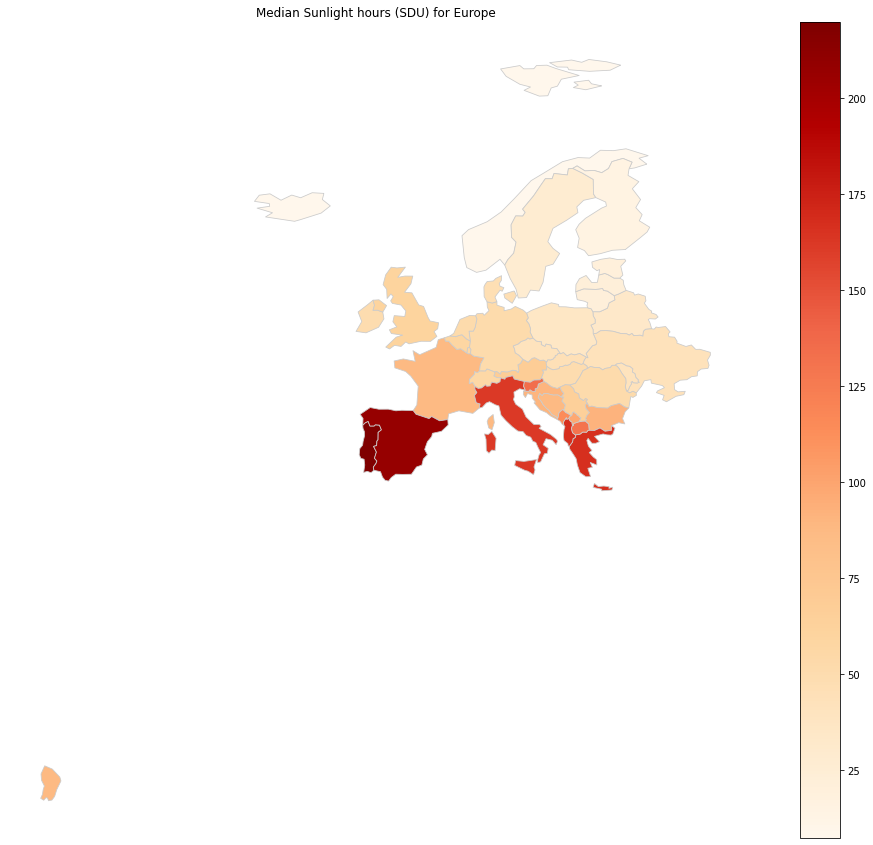

In [11]:
fig, ax = plt.subplots(1, figsize=(20, 15))
merged.plot(column='SDU', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.axis('off')
plt.title("Median Sunlight hours (SDU) for Europe");

# Dataset 2: Sun phases (Sunrise-Sunset) creation via Astral package

In [12]:
from astral.geocoder import database, lookup
from astral.sun import sun
from unidecode import unidecode
from countryinfo import CountryInfo

First, get all capital cities for all EU countries, as the astral library works on capitals only:

In [13]:
country = CountryInfo()
iso_to_cap = {v['ISO']['alpha3']: v['capital'] for k,v in country.all().items() if 'capital' in v.keys()}

In [14]:
iso_to_cap_EU = {k:v for k,v in iso_to_cap.items() if k in europe['iso_a3'].tolist()}

In [33]:
# Normalize capital names
iso_to_cap_EU_norm = {k:unidecode(v) for k,v in iso_to_cap_EU.items()}

Get sunset and sunrise data for all European countries.
Times are all in UTC.
We convert the results to a dataframe with separate columns for the year, month and day columns.
The format is as follows:
Country code (ISO_A3), City, Day, Month, Year, Sunrise Hour (24h UTC), Sunset Hour (24h UTC)

This will allow the aggregation over days, months, years, etc. to build visualizations on top of.

In [34]:
from datetime import datetime

dates = [datetime.now()]

In [35]:
sun_data = []
for country_isoa3,capital in iso_to_cap_EU_norm.items():
    city = lookup(capital, database())
    for date in dates:
        sun_city = sun(city.observer, date=date)
        sunrise = sun_city['sunrise']
        sunset = sun_city['sunset']
        sun_data.append([country_isoa3, capital, date.day, date.month, date.year, sunrise.hour, sunset.hour])

In [59]:
sun_info_df = pd.DataFrame(sun_data, columns=['iso_a3', 'capital', 'day', 'month', 'year', 'sunrise_UTC', 'sunset_UTC'])

### Create a cloropleth plot for the sunrise/sunset

First we will have to merge the df with the europe geo dataframe again:

In [60]:
europe_plot = europe.loc[:, ['iso_a3', 'geometry']]

In [69]:
sun_info_plot = gpd.GeoDataFrame(sun_info_df.merge(europe_plot, on='iso_a3', how='left').set_index('iso_a3'))
sun_info_plot.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 36 entries, ALB to GBR
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   capital      36 non-null     object  
 1   day          36 non-null     int64   
 2   month        36 non-null     int64   
 3   year         36 non-null     int64   
 4   sunrise_UTC  36 non-null     int64   
 5   sunset_UTC   36 non-null     int64   
 6   geometry     36 non-null     geometry
dtypes: geometry(1), int64(5), object(1)
memory usage: 3.3+ KB


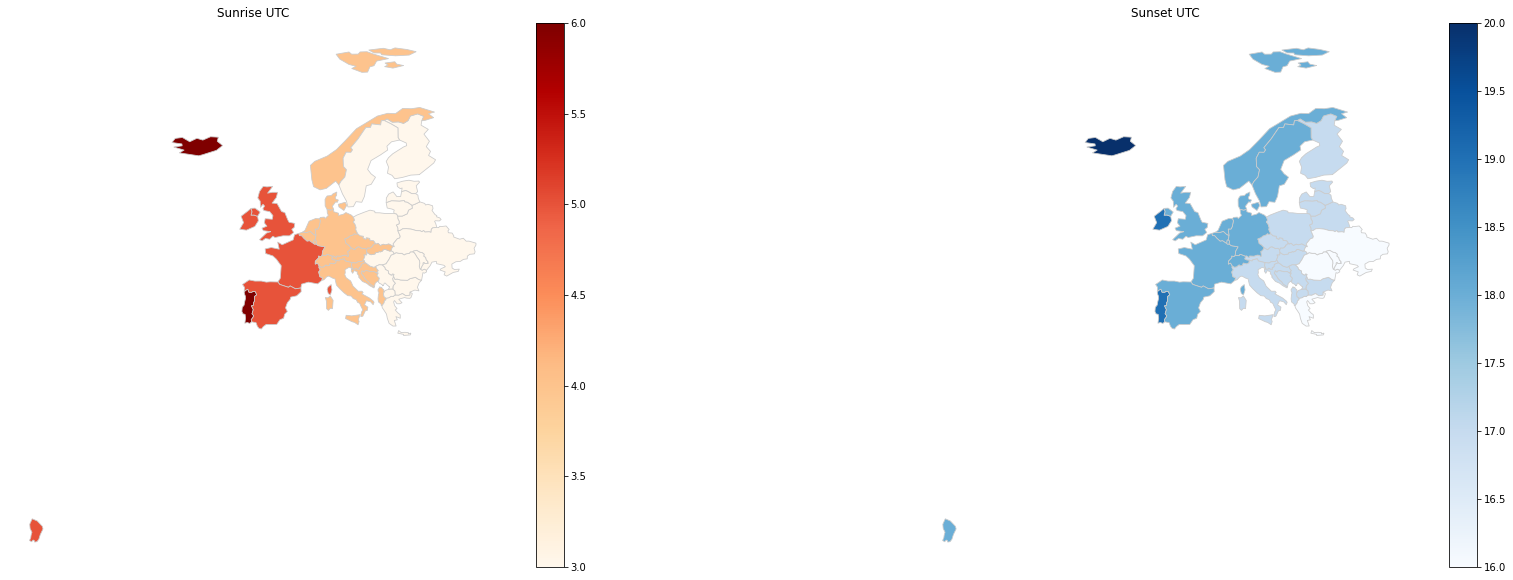

In [83]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
sun_info_plot.plot(column='sunrise_UTC', cmap='OrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=True)
sun_info_plot.plot(column='sunset_UTC', cmap='Blues', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=True)
for a in axs:
    a.axis('off')
axs[0].set_title('Sunrise UTC')
axs[1].set_title('Sunset UTC');